# Data Scientist Challenge | Marcelo Torres Cisterna

El presente notebook tiene por objetivo el desarrollo de un modelo de IA que permita identificar la probabilidad que un vuelo se atrase o no. Es conocido que éste es un problema que se da en la realidad y lo ideal es minimizar estos atrasos lo máximo posible.

# <font color='darkblue'>Estructura del Notebook</font>

[Sección 1 : Exploratory Data Analysis](#Sección-1-:-Exploratory-Data-Analysis)    
- [Sección 1.1 : Análisis Por Fechas](#Sección-1.1-:-Análisis-Por-Fechas)
- [Sección 1.2 : Análisis Por Origen y Destino](#Sección-1.2-:-Análisis-Por-Origen-y-Destino)
- [Sección 1.3 : Análisis Por Aerolínea](#Sección-1.3-:-Análisis-Por-Aerolínea)

[Sección 2 : Synthetic Features](#Sección-2-:-Synthetic-Features) 
- [Sección 2.1 : Temporada Alta](#Sección-2.1-:-Temporada-Alta)
- [Sección 2.2 : Diferencia Minutos](#Sección-2.2-:-Diferencia-Minutos)
- [Sección 2.3 : Atraso 15](#Sección-2.3-:-Atraso-15)
- [Sección 2.4 : Período Día](#Sección-2.4-:-Período-Día)

[Sección 3 : Tasas de Atrasos](#Sección-3-:-Tasas-de-Atrasos) 
- [Sección 3.1 : Destino](#Sección-3.1-:-Destino) 
- [Sección 3.2 : Aerolínea](#Sección-3.2-:-Aerolínea)
- [Sección 3.3 : Mes](#Sección-3.3-:-Mes)
- [Sección 3.4 : Día](#Sección-3.4-:-Día)
- [Sección 3.5 : Temporada](#Sección-3.5-:-Temporada)
- [Sección 3.6 : Tipo de Vuelo](#Sección-3.6-:-Tipo-de-Vuelo)
- [Sección 3.7 : Período Día](#Sección-3.7-:-Período-Día)
- [Sección 3.8 : Variables Interesantes para el Estudio](#Sección-3.8-:-Variables-Interesantes-para-el-Estudio)

[Sección 4 : Desarrollo de Modelos](#Sección-4-:-Desarrollo-de-Modelos) 
- [Sección 4.1 : Preparando un poco más los Datos](#Sección-4.1-:-Preparando-un-poco-más-los-Datos)
- [Sección 4.2 : Analizando Solo Los Vuelos Atrasados](#Sección-4.2-:-Analizando-Solo-Los-Vuelos-Atrasados)
- [Sección 4.3 : Modelo sin incluir las Tasas](#Sección-4.3-:-Modelo-sin-incluir-las-Tasas)
 - [Sección 4.3.1 : Logistic Regression](#Sección-4.3.1-:-Logistic-Regression)
  - [Sección 4.3.2 : XGBoost](#Sección-4.3.2-:-XGBoost)
  - [Sección 4.3.3 : Random Forest](#Sección-4.3.3-:-Random-Forest)
  - [Sección 4.3.4 : Decision Tree](#Sección-4.3.4-:-Decision-Tree)  
  
  
- [Sección 4.4 : Modelo incluyendo Solo Tasas](#Sección-4.4-:-Modelo-incluyendo-Solo-Tasas)
 - [Sección 4.4.1 : Logistic Regression](#Sección-4.4.1-:-Logistic-Regression)
  - [Sección 4.4.2 : XGBoost](#Sección-4.4.2-:-XGBoost)
  - [Sección 4.4.3 : Random Forest](#Sección-4.4.3-:-Random-Forest)
  - [Sección 4.4.4 : Decision Tree](#Sección-4.4.4-:-Decision-Tree) 
  
  
- [Sección 4.5 : Modelo incluyendo Tasas y Variables Anteriores](#Sección-4.5-:-Modelo-incluyendo-Tasas-y-Variables-Anteriores)
 - [Sección 4.5.1 : Logistic Regression](#Sección-4.5.1-:-Logistic-Regression)
  - [Sección 4.5.2 : XGBoost](#Sección-4.5.2-:-XGBoost)
  - [Sección 4.5.3 : Random Forest](#Sección-4.5.3-:-Random-Forest)
  - [Sección 4.5.4 : Decision Tree](#Sección-4.5.4-:-Decision-Tree)

[Sección 5 : Evaluación de Modelos](#Sección-5-:-Evaluación-de-Modelos)  


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [2]:
data = pd.read_csv("dataset_SCL.csv")

C:\Users\marce\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Sección 1 : Exploratory Data Analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


In [4]:
data.describe()

,DIA,MES,AÑO
count,68206.000000,68206.000000,68206.000000
mean,15.714790,6.622585,2017.000029
std,8.782886,3.523321,0.005415
min,1.000000,1.000000,2017.000000
25%,8.000000,3.000000,2017.000000
50%,16.000000,7.000000,2017.000000
75%,23.000000,10.000000,2017.000000
max,31.000000,12.000000,2018.000000


Primero, notamos que existen algunas Features que corresponden a fechas, pero no están en formato datetime, formato que nos facilita mucho más el trabajo para obtener datos a partir de fechas.

In [5]:
data[["Fecha-I", "Fecha-O"]] = data[["Fecha-I", "Fecha-O"]].apply(pd.to_datetime)

Usando el nuevo formato, obtenemos algunas Features nuevas para nuestro análisis.

In [6]:
data['year-I'] = [x.year for x in data["Fecha-I"]]
data['year-O'] = [x.year for x in data["Fecha-O"]]
data['month-I'] = [x.month for x in data["Fecha-I"]]
data['month-O'] = [x.month for x in data["Fecha-O"]]    
data['day-I'] = [x.day for x in data["Fecha-I"]]
data['day-O'] = [x.day for x in data["Fecha-O"]]    

Borramos features repetidas

In [7]:
data.drop(["DIA" , "MES" , "AÑO"] , axis = 1 , inplace = True)

In [8]:
data.groupby(["year-I","year-O"]).size()

year-I  year-O
2017    2017      68204
        2018          2
dtype: int64

Notamos que el dataset se basa en datos del año 2017, hay dos vuelos cuya fecha de operación es de 2018 y eso es porque el vuelo estaba programado para el 31 de Diciembre y operó pasada las 00 horas.

## Sección 1.1 : Análisis Por Fechas

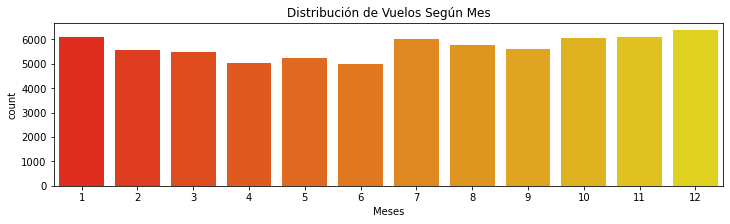

In [9]:
plt.figure(figsize =(12,3))
plt.title("Distribución de Vuelos Según Mes")
sns.countplot(x = "month-I" , data = data , palette = "autumn")
plt.xlabel("Meses");

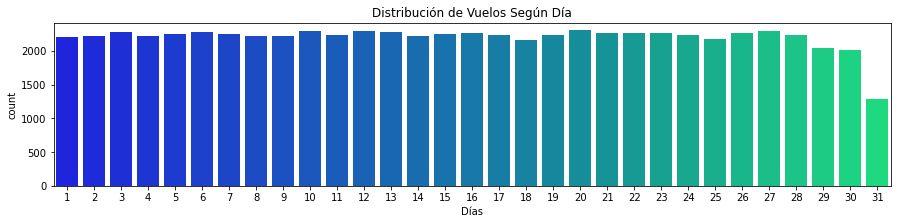

In [10]:
plt.figure(figsize =(15,3))
plt.title("Distribución de Vuelos Según Día")
sns.countplot(x = "day-I" , data = data , palette = "winter")
plt.xlabel("Días");

Notamos que en cuanto a la distribución __Mensual__ de los datos, hay tres fechas principales en las que se presenta una mayor cantidad de vuelos: __Enero, Julio y Diciembre__. A priori, una conclusión de lo anterior es debido a las fechas relacionadas a las vacaciones de verano e invierno. Por otra parte, cuando analizamos el comportamiento diario notamos un patrón más o menos similar a excepción del día __31 de Diciembre__, lo anterior probablemente ya que es el día de año nuevo y muchas personas probablemente quieran pasar ese día festivo con familiares y amigos.

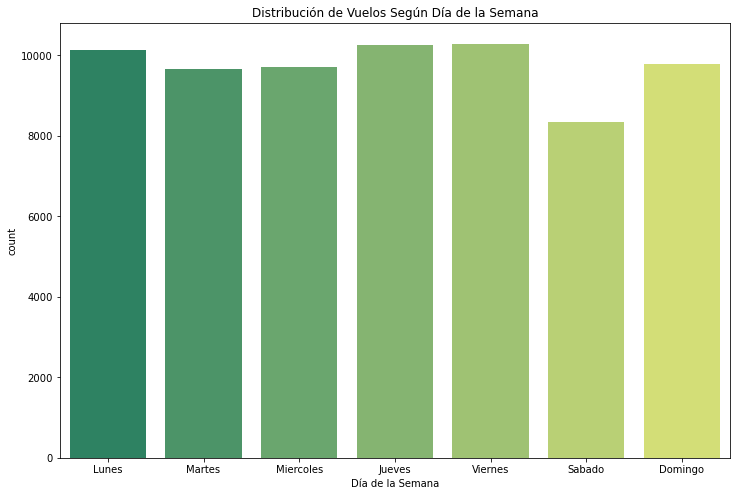

In [11]:
plt.figure(figsize =(12,8))
plt.title("Distribución de Vuelos Según Día de la Semana")
sns.countplot(x = "DIANOM" , data = data , palette = "summer" , order=['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes' , 'Sabado' , 'Domingo'])
plt.xlabel("Día de la Semana");

En cuanto a día de la semana __Lunes , Jueves y Viernes__ lideran los vuelos.

## Sección 1.2 : Análisis Por Origen y Destino

In [12]:
data.groupby("Ori-I").size()

Ori-I
SCEL    68206
dtype: int64

In [13]:
data.groupby("Ori-O").size()

Ori-O
SCEL    68206
dtype: int64

In [14]:
data.groupby("SIGLAORI").size()

SIGLAORI
Santiago    68206
dtype: int64

Aquí es donde notamos algo interesante. Todos los vuelos del dataset tienen como origen tanto programado como de operación la ciudad de Santiago. Lo anterior quiere decir que todos los vuelos son solamente vuelos __desde__ Santiago y no __desde y hacia__ como menciona la descripción del dataset. Por lo tanto éstas columnas no nos sirven y se eliminan.

In [15]:
data.drop(["Ori-I" , "Ori-O" , "SIGLAORI"] , axis = 1 , inplace = True)

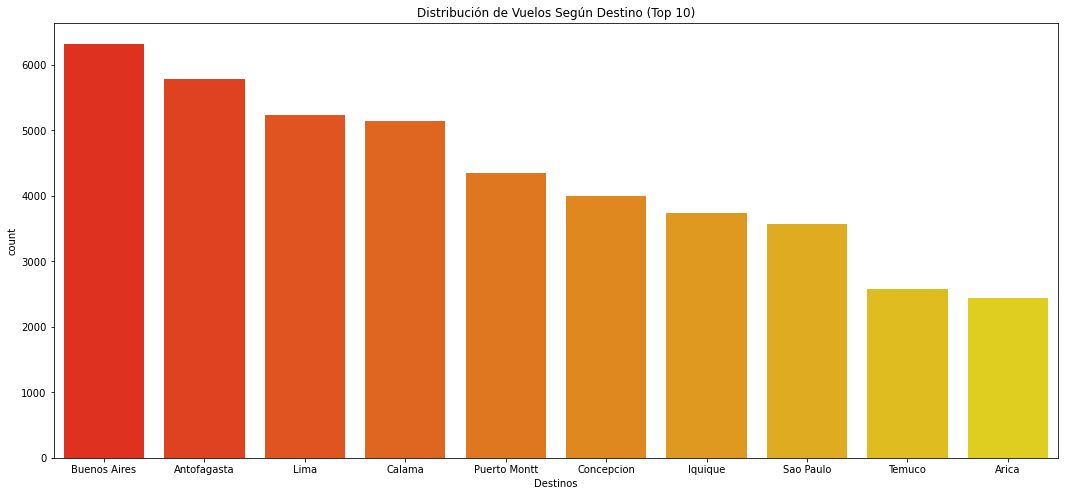

In [98]:
plt.figure(figsize =(18,8))
plt.title("Distribución de Vuelos Según Destino (Top 10)")
sns.countplot(x = "SIGLADES" , data = data , palette = "autumn" , order = data['SIGLADES'].value_counts().index[:10]);
plt.xlabel("Destinos");

In [17]:
data["DestVerificacion"] = data["Des-I"] == data["Des-O"]

In [18]:
data.groupby("DestVerificacion").size()

DestVerificacion
False       28
True     68178
dtype: int64

La ubicación con la mayor cantidad de viajes corresponde a la ciudad de __Buenos Aires__ seguido de __Antofagasta__ . Otra cosa importante que notamos es que hay 28 casos en los que el __Destino Programado__ es diferente al __Destino de Operación__ . Esta situación resulta un poco extraña ya que cuando uno agenda un vuelo, uno espera llegar al destino que fue solicitado y no otro. El hecho que existieran algunos vuelos en los que estos destinos eran diferentes se pudo haber debido por ejemplo a alguna falla técnica que generó algún aterrizaje de emergencia o algo por el estilo. Para efectos del estudio, se considerarán como __Outliers__.

In [19]:
data = data[data.DestVerificacion == True]

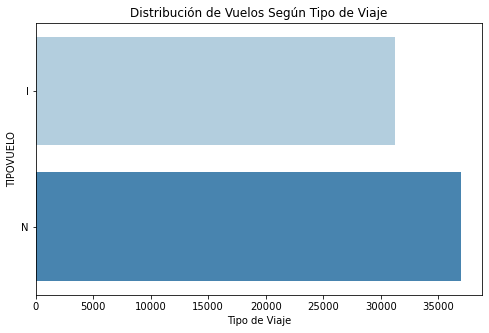

In [20]:
plt.figure(figsize =(8,5))
plt.title("Distribución de Vuelos Según Tipo de Viaje")
sns.countplot(y = "TIPOVUELO" , data = data , palette = "Blues");
plt.xlabel("Tipo de Viaje");

Por otra parte, la cantidad de vuelos tanto __Nacionales como Internacionales__ es más o menos similar.

## Sección 1.3 : Análisis Por Aerolínea

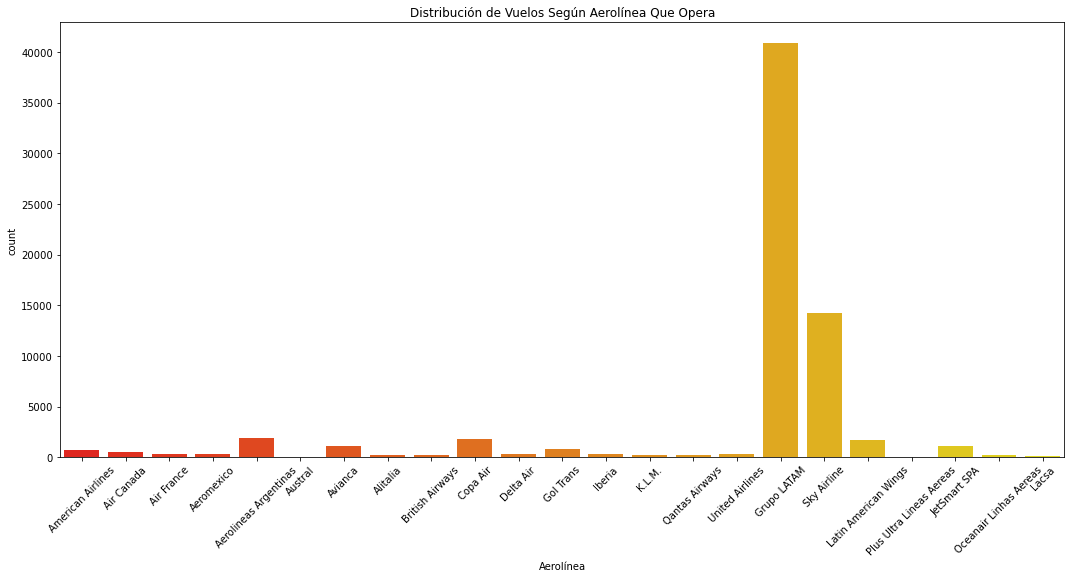

In [21]:
plt.figure(figsize =(18,8))
plt.title("Distribución de Vuelos Según Aerolínea Que Opera")
sns.countplot(x = "OPERA" , data = data , palette = "autumn");
plt.xlabel("Aerolínea")
plt.xticks(rotation=45);

In [22]:
data["EmpVer"] = data["Emp-I"] == data["Emp-O"]

In [23]:
data.groupby("EmpVer").size()

EmpVer
False    18659
True     49519
dtype: int64

In [24]:
data[data.EmpVer == False].head()

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLADES,year-I,year-O,month-I,month-O,day-I,day-O,DestVerificacion,EmpVer
345,2017-01-21 22:30:00,2291,SABE,AUT,2017-01-21 22:28:00,2291,SABE,ARG,Sabado,I,Austral,Buenos Aires,2017,2017,1,1,21,21,True,False
814,2017-01-01 07:14:00,624,SPJC,AVA,2017-01-01 07:11:00,624,SPJC,LRC,Domingo,I,Avianca,Lima,2017,2017,1,1,1,1,True,False
815,2017-01-02 07:00:00,624,SPJC,AVA,2017-01-02 07:05:00,624,SPJC,LRC,Lunes,I,Avianca,Lima,2017,2017,1,1,2,2,True,False
816,2017-01-03 07:14:00,624,SPJC,AVA,2017-01-03 07:14:00,624,SPJC,LRC,Martes,I,Avianca,Lima,2017,2017,1,1,3,3,True,False
817,2017-01-04 07:00:00,624,SPJC,AVA,2017-01-04 07:24:00,624,SPJC,LRC,Miercoles,I,Avianca,Lima,2017,2017,1,1,4,4,True,False


Aquí notamos otra característica interesante de los datos. Existe una gran cantidad de vuelos en los que la empresa que en realidad operó fue diferente a la que debió haber operado. Sin embargo, puede que la aerolínea que en realidad operó sea parte de un Grupo, por lo que la tesis anterior estaría equivocada. Para lo anterior creamos una columna que mapea código de aerolínea con nombre de la aerolínea

In [25]:
aerodict = data[["Emp-I" , "OPERA"]].drop_duplicates()
aerodict.rename(columns = {
    'Emp-I' : 'Emp-O',
    'OPERA' : 'OPERA-O'
} , inplace = True)

In [26]:
data = pd.merge(data,aerodict, how = "left")
data['OPERA-O'] = data["OPERA-O"].fillna(value = "Unknown")

In [27]:
data[data['OPERA-O'] == "Unknown"].groupby("Emp-I").size()

Emp-I
AVA      2
LAW     27
QFU    194
dtype: int64

In [28]:
data[(data['OPERA-O'] == "Unknown") & (data["Emp-I"] == "AVA")]

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLADES,year-I,year-O,month-I,month-O,day-I,day-O,DestVerificacion,EmpVer,OPERA-O
39174,2017-08-11 06:14:00,624,SPJC,AVA,2017-08-11 08:14:00,922,SPJC,TPU,Viernes,I,Avianca,Lima,2017,2017,8,8,11,11,True,False,Unknown
39180,2017-08-17 17:25:00,624,SPJC,AVA,2017-08-17 19:21:00,5924,SPJC,TPU,Jueves,I,Avianca,Lima,2017,2017,8,8,17,17,True,False,Unknown


In [29]:
data[(data['OPERA-O'] == "Unknown") & (data["Emp-I"] == "QFU")].head(2)

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLADES,year-I,year-O,month-I,month-O,day-I,day-O,DestVerificacion,EmpVer,OPERA-O
845,2017-01-01 13:35:00,28,YSSY,QFU,2017-01-01 14:56:00,28,YSSY,QFA,Domingo,I,Qantas Airways,Sydney,2017,2017,1,1,1,1,True,False,Unknown
846,2017-01-03 13:35:00,28,YSSY,QFU,2017-01-03 14:12:00,28,YSSY,QFA,Martes,I,Qantas Airways,Sydney,2017,2017,1,1,3,3,True,False,Unknown


Existen 3 códigos de aerolíneas que no cuentan con un nombre en particular. Notamos que uno de ellos es __QFA__ que podemos intuir que pertenece a la misma aerolínea que __QFU__ por lo que haremos ese reemplazo. Los otros vuelos de las aerolíneas AVA y LAW, al ser una cantidad muy pequeña los omitiremos

In [30]:
data1 = data[data["OPERA-O"] != "Unknown"]
data2 = data[(data["OPERA-O"] == "Unknown") & (data["Emp-I"] == "QFU")]
data2["OPERA-O"] = "Qantas Airways"
data = pd.concat([data1 , data2])
data["EmpVer2"] = data["OPERA"] == data["OPERA-O"]
data.groupby("EmpVer2").size()

<ipython-input-30-cae10daab30d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2["OPERA-O"] = "Qantas Airways"


EmpVer2
False      272
True     67877
dtype: int64

In [31]:
data[data.EmpVer2 == False].groupby("Emp-I").size()

Emp-I
ARG      5
AUT      2
AVA    265
dtype: int64

In [32]:
data[(data.EmpVer2 == False) & (data["Emp-I"] != "AVA")]

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLADES,year-I,year-O,month-I,month-O,day-I,day-O,DestVerificacion,EmpVer,OPERA-O,EmpVer2
345,2017-01-21 22:30:00,2291,SABE,AUT,2017-01-21 22:28:00,2291,SABE,ARG,Sabado,I,Austral,Buenos Aires,2017,2017,1,1,21,21,True,False,Aerolineas Argentinas,False
11987,2017-03-04 22:30:00,2291,SABE,ARG,2017-03-04 22:34:00,2291,SABE,AUT,Sabado,I,Aerolineas Argentinas,Buenos Aires,2017,2017,3,3,4,4,True,False,Austral,False
11988,2017-03-11 22:30:00,2291,SABE,ARG,2017-03-11 22:39:00,2291,SABE,AUT,Sabado,I,Aerolineas Argentinas,Buenos Aires,2017,2017,3,3,11,11,True,False,Austral,False
11989,2017-03-25 22:30:00,2291,SABE,ARG,2017-03-25 22:39:00,2291,SABE,AUT,Sabado,I,Aerolineas Argentinas,Buenos Aires,2017,2017,3,3,25,25,True,False,Austral,False
32735,2017-07-22 19:50:00,2297,SABE,AUT,2017-07-22 19:46:00,1297,SABE,ARG,Sabado,I,Austral,Buenos Aires,2017,2017,7,7,22,22,True,False,Aerolineas Argentinas,False
62152,2017-12-20 19:25:00,2287,SAEZ,ARG,2017-12-20 20:17:00,1287,SAEZ,AUT,Miercoles,I,Aerolineas Argentinas,Buenos Aires,2017,2017,12,12,20,20,True,False,Austral,False
62153,2017-12-22 19:25:00,2287,SAEZ,ARG,2017-12-22 21:30:00,2287,SAEZ,AUT,Viernes,I,Aerolineas Argentinas,Buenos Aires,2017,2017,12,12,22,22,True,False,Austral,False


Realizando un poco de investigación, resulta que el nombre anterior de __AVIANCA__ era __LACSA__. Por otra parte notamos de la tabla superior que __Austral__ y __Aerolíneas Argentinas__ corresponden al mismo grupo. De ésta forma logramos rearmar el conjunto de datos verificando que aerolíneas de operación y programadas son correctas. Limpiamos el dataset eliminando variables que no utilizaremos y luego procedemos con la sección 2.

In [33]:
data = data.drop([ "DestVerificacion" , "EmpVer" , "OPERA-O" , "EmpVer2"] , axis = 1)

# Sección 2 : Synthetic Features

In [34]:
synthetic_features = pd.DataFrame(columns = ['fecha_I' , 'fecha_O','temporada_alta', 'dif_min', 'atraso_15' , 'periodo_dia'])

In [35]:
synthetic_features['fecha_I'] = data['Fecha-I']
synthetic_features['fecha_O'] = data['Fecha-O']

## Sección 2.1 : Temporada Alta

In [36]:
i1 = pd.Timestamp('2017-12-15T235959')
i2 = pd.Timestamp('2017-03-03T0000')
i3 = pd.Timestamp('2017-07-15T0000')
i4 = pd.Timestamp('2017-07-31T235959')
i5 = pd.Timestamp('2017-09-11T0000')
i6 = pd.Timestamp('2017-09-30T235959')

In [37]:
temporada_alta = []
for i in data['Fecha-I']:
    if (i > i1) | (i < i2) | (i3 <= i <= i4) | (i5 <= i <= i6):
        temporada_alta.append(1)
    else:
        temporada_alta.append(0)
synthetic_features['temporada_alta'] = temporada_alta

## Sección 2.2 : Diferencia Minutos

In [38]:
synthetic_features["late"] = [1 if i.fecha_I <= i.fecha_O else 0 for i in synthetic_features.itertuples()]
synthetic_features["dif_min"] = [int(np.round((i.fecha_I - i.fecha_O).seconds / 60 , 0)) if i.late == 0 else int(np.round((i.fecha_O - i.fecha_I).seconds / 60 , 0)) for i in synthetic_features.itertuples()]
synthetic_features.drop(["late"] , axis = 1 , inplace = True)

## Sección 2.3 : Atraso 15

In [39]:
synthetic_features["atraso_15"] = [1 if x > 15 else 0 for x in synthetic_features.dif_min]

## Sección 2.4 : Período Día

In [40]:
periodo_dia = []
for i in synthetic_features.itertuples():
    if (5 <= i.fecha_I.hour < 12):
        periodo_dia.append("mañana")
    elif (12 <= i.fecha_I.hour < 19):
        periodo_dia.append("tarde")
    else:
        periodo_dia.append("noche")
synthetic_features["periodo_dia"] = periodo_dia

In [41]:
synthetic_features.to_csv("synthetic_features.csv")

In [42]:
synthetic_features.drop(["fecha_I" , "fecha_O"] , axis = 1 , inplace = True)

In [43]:
data = pd.concat([data , synthetic_features] , axis = 1)

# Sección 3 : Tasas de Atrasos

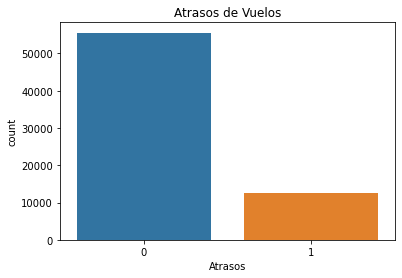

In [44]:
plt.title("Atrasos de Vuelos")
sns.countplot(x='atraso_15' , data=data);
plt.xlabel("Atrasos");

Podemos notar que claramente hay un significativo desbalanceo de clases, lo cual generará ciertos conflictos al momento de entrenar el modelo. Además utilizar __Accuracy__ no será lo adecuado dado el desbalanceo existente

In [45]:
def rates(data , category):
    vuelos = pd.crosstab(data[category], data['atraso_15'])
    vuelos.columns = ["no_atrasado" , "atrasado"]
    vuelos['total_vuelos'] = vuelos.no_atrasado + vuelos.atrasado
    tasas = pd.crosstab(data[category], data['atraso_15']).apply(lambda r: (r/r.sum()).round(2), axis=1)
    tasas.columns = ["rate_no_atrasado" , f"rate_atrasado_{category}"]
    df = pd.concat([vuelos , tasas] , axis = 1)
    return df

## Sección 3.1 : Destino

In [46]:
dest_rates = rates(data , 'SIGLADES')

In [47]:
dest_rates = dest_rates.sort_values(by = "rate_atrasado_SIGLADES" , ascending = False)[:15]

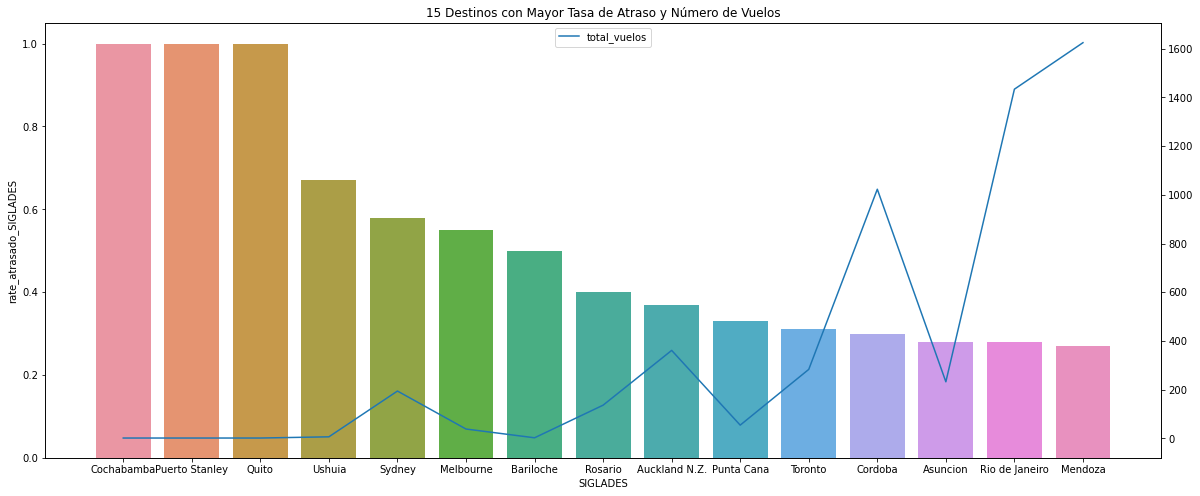

In [48]:
plt.figure(figsize = (20,8))
plt.title("15 Destinos con Mayor Tasa de Atraso y Número de Vuelos")
sns.barplot(x = dest_rates.index, y = "rate_atrasado_SIGLADES" , data = dest_rates)
dest_rates['total_vuelos'].plot(secondary_y=True)
plt.legend(loc="upper center");

__OBS__: La razón por la que se utilizó un gráfico de barras para las tasas y uno de líneas para la cantidad de vuelos es porque resultaba más claro de esta forma que de la forma inversa.

In [49]:
dest_rates.head(10)

,no_atrasado,atrasado,total_vuelos,rate_no_atrasado,rate_atrasado_SIGLADES
SIGLADES,,,,,
Cochabamba,0,1,1,0.00,1.00
Puerto Stanley,0,1,1,0.00,1.00
Quito,0,1,1,0.00,1.00
Ushuia,2,4,6,0.33,0.67
Sydney,81,113,194,0.42,0.58
Melbourne,17,21,38,0.45,0.55
Bariloche,1,1,2,0.50,0.50
Rosario,82,54,136,0.60,0.40
Auckland N.Z.,226,135,361,0.63,0.37


La figura anterior indica los 15 destinos con mayor tasa de atrasos. Los rectángulos representan la tasa y la línea la cantidad de vuelos de dicho destino. Resulta importante notar que __Cochabamba, Puerto Stanley y Quito__ son destinos con un __100%__ de tasas de atrasos. Resulta importante notar que estos destinos solo cuentan con __un__ solo viaje. Distinto es el panorama con destinos como __Sydney , Melbourne, Rosario y Auckland__ en los cuales hay una cantidad considerable de viajes.

In [50]:
dest_rates = rates(data , 'SIGLADES')

## Sección 3.2 : Aerolínea

In [51]:
aero_rates = rates(data , 'OPERA')

In [52]:
aero_rates.sort_values(by = "rate_atrasado_OPERA" , ascending = False).head(5)

,no_atrasado,atrasado,total_vuelos,rate_no_atrasado,rate_atrasado_OPERA
OPERA,,,,,
Plus Ultra Lineas Aereas,19,30,49,0.39,0.61
Qantas Airways,81,113,194,0.42,0.58
Air Canada,307,258,565,0.54,0.46
Latin American Wings,979,667,1646,0.59,0.41
Gol Trans,518,287,805,0.64,0.36


In [53]:
aero_rates.sort_values(by = "rate_atrasado_OPERA" , ascending = False).tail(5)

,no_atrasado,atrasado,total_vuelos,rate_no_atrasado,rate_atrasado_OPERA
OPERA,,,,,
American Airlines,706,51,757,0.93,0.07
Copa Air,1734,116,1850,0.94,0.06
Delta Air,337,21,358,0.94,0.06
United Airlines,317,17,334,0.95,0.05
Aeromexico,341,10,351,0.97,0.03


En cuanto a las Aerolíneas, __Plus Ultra Lineas Aeresas y Qantas Airways__ presentan más de un 58% de atrasos en sus vuelos, siendo las aerolíneas con peor rendimiento. En contraste, __United Airlines y Aeromexico__ las mejores con menos de un 5% de atrasos.

## Sección 3.3 : Mes

In [54]:
mes_rates = rates(data , 'month-O')

In [55]:
mes_rates

,no_atrasado,atrasado,total_vuelos,rate_no_atrasado,rate_atrasado_month-O
month-O,,,,,
1,5116,964,6080,0.84,0.16
2,4716,842,5558,0.85,0.15
3,4848,630,5478,0.88,0.12
4,4433,585,5018,0.88,0.12
5,4409,827,5236,0.84,0.16
6,4129,852,4981,0.83,0.17
7,4232,1755,5987,0.71,0.29
8,4746,994,5740,0.83,0.17
9,4643,967,5610,0.83,0.17


En cuanto a la tasa de atraso mensual, las variaciones son menos notorias siendo la más alta en __Julio__ con un __29%__ y la más baja en __Marzo y Abril__ con __12%__.

## Sección 3.4 : Día

In [56]:
day_rates = rates(data , 'DIANOM')

In [57]:
day_rates

,no_atrasado,atrasado,total_vuelos,rate_no_atrasado,rate_atrasado_DIANOM
DIANOM,,,,,
Domingo,8214,1576,9790,0.84,0.16
Jueves,8202,2043,10245,0.80,0.20
Lunes,8078,2043,10121,0.80,0.20
Martes,8025,1627,9652,0.83,0.17
Miercoles,8054,1658,9712,0.83,0.17
Sabado,6984,1363,8347,0.84,0.16
Viernes,8001,2281,10282,0.78,0.22


La tasa de atrasos diaria presenta incluso aun menos variabilidad oscilando entre un 16 a 22%.

## Sección 3.5 : Temporada

In [58]:
temp_rates = rates(data , 'temporada_alta')

In [59]:
temp_rates

,no_atrasado,atrasado,total_vuelos,rate_no_atrasado,rate_atrasado_temporada_alta
temporada_alta,,,,,
0,37590,8239,45829,0.82,0.18
1,17968,4352,22320,0.81,0.19


No hay ninguna diferencia en la tasa de atrasos a nivel de temporadas.

## Sección 3.6 : Tipo de Vuelo

In [60]:
tipo_rates = rates(data , 'TIPOVUELO')

In [61]:
tipo_rates

,no_atrasado,atrasado,total_vuelos,rate_no_atrasado,rate_atrasado_TIPOVUELO
TIPOVUELO,,,,,
I,24169,7028,31197,0.77,0.23
N,31389,5563,36952,0.85,0.15


Finalmente y como era de esperar, los vuelos internacionales presentan un __10%__ más de atrasos que los vuelos nacionales.

## Sección 3.7 : Período Día

In [62]:
periodo_rates = rates(data , 'periodo_dia')
periodo_rates

,no_atrasado,atrasado,total_vuelos,rate_no_atrasado,rate_atrasado_periodo_dia
periodo_dia,,,,,
mañana,21274,4052,25326,0.84,0.16
noche,13869,3456,17325,0.80,0.20
tarde,20415,5083,25498,0.80,0.20


A continuación incorporamos las variables calculadas al dataframe original

In [63]:
dest_rates = dest_rates[["rate_atrasado_SIGLADES"]].reset_index()
aero_rates = aero_rates[["rate_atrasado_OPERA"]].reset_index()
mes_rates = mes_rates[["rate_atrasado_month-O"]].reset_index()
day_rates = day_rates[["rate_atrasado_DIANOM"]].reset_index()
temp_rates = temp_rates[["rate_atrasado_temporada_alta"]].reset_index()
tipo_rates = tipo_rates[["rate_atrasado_TIPOVUELO"]].reset_index()
periodo_rates = periodo_rates[["rate_atrasado_periodo_dia"]].reset_index()

In [64]:
data = pd.merge(data , dest_rates)
data = pd.merge(data , aero_rates)
data = pd.merge(data , mes_rates)
data = pd.merge(data , day_rates)
data = pd.merge(data , temp_rates)
data = pd.merge(data , tipo_rates)
data = pd.merge(data , periodo_rates)

## Sección 3.8 : Variables Interesantes para el Estudio

Seleccionar variables es un proceso bastante extenso ya que hay infinitas combinaciones posibles. Al momento de hacer este proceso personalmente, me enfoco en una primera instancia en aquellas variables que presenten una variabilidad importante entre ellas. Un contraejemplo de lo anterior sería la tasa de atraso de los vuelos en temporadas altas y bajas ya que son prácticamente idénticas, por lo cual no sería una variable ideal. A priori esperaría que las variables con mayor influencia fueran:

- __Aerolínea__ : Al analizar las tasas hay claramente algunas en las que un vuelo es más probable que se atrase, mientras otras tienen una puntualidad prácticamente excelente
- __Destino__ : Destinos como Sydney y Melbourne que cuentan con una gran cantidad de vuelos, poseen tasas de atrasos de más del 55% lo cual entrega un precedente que hay sectores más conflictivos que otros

- __Mes__ : Julio y Agosto presentan mayor atraso que el resto de los meses probablemente porque son viajes que están muy relacionados con las vacaciones de invierno y verano por lo que existe un mayor flujo de personas

- __Período__ : Viajar en la mañana claramente representa una menor posibilidad de atraso que en la tarde y en la noche

# Sección 4 : Desarrollo de Modelos

## Sección 4.1 : Preparando un poco más los Datos

In [65]:
df = data.drop(['Fecha-I', 'Vlo-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O', 'Des-O' , "Emp-O" , 'year-I', 'year-O',
       'month-I', 'month-O', 'day-I', 'day-O' ,'dif_min', 'rate_atrasado_temporada_alta'] , axis = 1)

In [66]:
df.head(5)

,DIANOM,TIPOVUELO,OPERA,SIGLADES,temporada_alta,atraso_15,periodo_dia,rate_atrasado_SIGLADES,rate_atrasado_OPERA,rate_atrasado_month-O,rate_atrasado_DIANOM,rate_atrasado_TIPOVUELO,rate_atrasado_periodo_dia
0,Domingo,I,American Airlines,Miami,1,0,noche,0.19,0.07,0.16,0.16,0.23,0.2
1,Domingo,I,American Airlines,Miami,1,0,noche,0.19,0.07,0.16,0.16,0.23,0.2
2,Domingo,I,American Airlines,Miami,1,0,noche,0.19,0.07,0.16,0.16,0.23,0.2
3,Domingo,I,American Airlines,Miami,1,0,noche,0.19,0.07,0.16,0.16,0.23,0.2
4,Domingo,I,American Airlines,Miami,1,0,noche,0.19,0.07,0.16,0.16,0.23,0.2


## Sección 4.2 : Analizando Solo Los Vuelos Atrasados

In [67]:
atrasos = df[df.atraso_15 == 1]

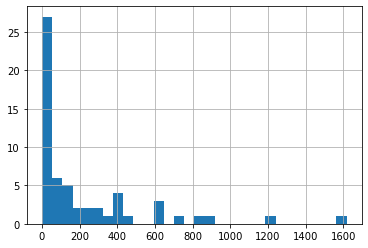

In [68]:
atrasos.groupby(["SIGLADES"]).size().sort_values(ascending = False).hist(bins = 30);

In [69]:
des_atrasos = pd.DataFrame(atrasos.groupby(["SIGLADES"]).size().sort_values(ascending = False) , columns = ["atrasos_des"])
des_atrasos.reset_index(inplace = True)

In [70]:
atrasos_count = []
for i in des_atrasos.atrasos_des:
    if i <= 200:
        atrasos_count.append("poco_frecuente_des")
    elif 200 < i <=600:
        atrasos_count.append("medio_frecuente_des")
    else:
        atrasos_count.append("muy_frecuente_des")
des_atrasos["freq_atraso_siglades"] = atrasos_count

In [71]:
opera_atrasos = pd.DataFrame(atrasos.groupby(["OPERA"]).size().sort_values(ascending = False) , columns = ["atrasos_opera"])
opera_atrasos.reset_index(inplace = True)

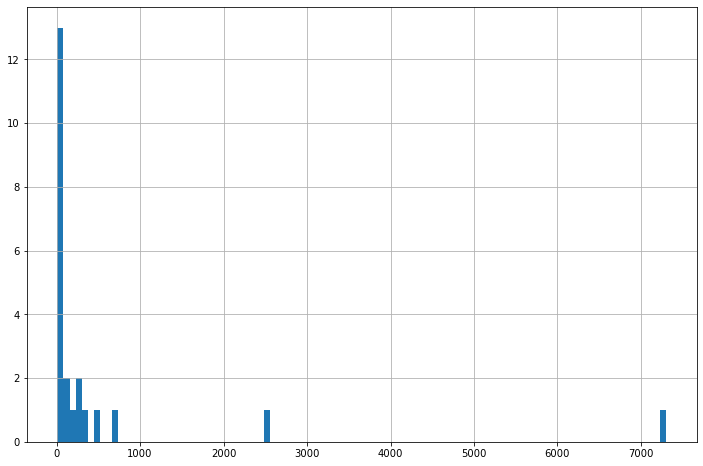

In [72]:
atrasos.groupby(["OPERA"]).size().sort_values(ascending = False).hist(bins = 100, figsize = (12,8));

In [73]:
atrasos_count = []
for i in opera_atrasos.atrasos_opera:
    if i <= 200:
        atrasos_count.append("poco_frecuente_opera")
    elif 200 < i <=600:
        atrasos_count.append("medio_frecuente_opera")
    else:
        atrasos_count.append("muy_frecuente_opera")
opera_atrasos["freq_atraso_opera"] = atrasos_count

In [74]:
df = pd.merge(df , des_atrasos, how = "left").fillna("poco_frecuente_des")

In [75]:
df = pd.merge(df , opera_atrasos, how = "left").fillna("poco_frecuente_opera")

In [76]:
X = df.drop("atraso_15" , axis = 1)
y = df[["atraso_15"]]

In [77]:
X

,DIANOM,TIPOVUELO,OPERA,SIGLADES,temporada_alta,periodo_dia,rate_atrasado_SIGLADES,rate_atrasado_OPERA,rate_atrasado_month-O,rate_atrasado_DIANOM,rate_atrasado_TIPOVUELO,rate_atrasado_periodo_dia,atrasos_des,freq_atraso_siglades,atrasos_opera,freq_atraso_opera
0,Domingo,I,American Airlines,Miami,1,noche,0.19,0.07,0.16,0.16,0.23,0.2,193,poco_frecuente_des,51,poco_frecuente_opera
1,Domingo,I,American Airlines,Miami,1,noche,0.19,0.07,0.16,0.16,0.23,0.2,193,poco_frecuente_des,51,poco_frecuente_opera
2,Domingo,I,American Airlines,Miami,1,noche,0.19,0.07,0.16,0.16,0.23,0.2,193,poco_frecuente_des,51,poco_frecuente_opera
3,Domingo,I,American Airlines,Miami,1,noche,0.19,0.07,0.16,0.16,0.23,0.2,193,poco_frecuente_des,51,poco_frecuente_opera
4,Domingo,I,American Airlines,Miami,1,noche,0.19,0.07,0.16,0.16,0.23,0.2,193,poco_frecuente_des,51,poco_frecuente_opera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68144,Viernes,N,JetSmart SPA,Copiapo,0,tarde,0.14,0.18,0.25,0.22,0.15,0.2,242,medio_frecuente_des,196,poco_frecuente_opera
68145,Viernes,N,JetSmart SPA,Copiapo,0,tarde,0.14,0.18,0.25,0.22,0.15,0.2,242,medio_frecuente_des,196,poco_frecuente_opera
68146,Viernes,N,JetSmart SPA,Calama,0,tarde,0.12,0.18,0.25,0.22,0.15,0.2,629,muy_frecuente_des,196,poco_frecuente_opera
68147,Viernes,N,JetSmart SPA,Calama,0,tarde,0.12,0.18,0.25,0.22,0.15,0.2,629,muy_frecuente_des,196,poco_frecuente_opera


Existen ciertas variables categóricas como __Destino__ que son muy amplias para convertirlas en formato One Hot. Analizando el histograma de la distribución de tasas de atraso podemos crear una nueva variable (binning) que establezca el destino como __Atraso Bajo, Medio o Alto__. Establecemos los siguientes intervalos:
- __Atraso Bajo__ : Tasa de atraso menor a 20%
- __Atraso Medio__ : Tasa de atraso entre 20 y 40%
- __Atraso Alto__ : Tasa de atraso mayor a 40%

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D6B83BC580>]],
      dtype=object)

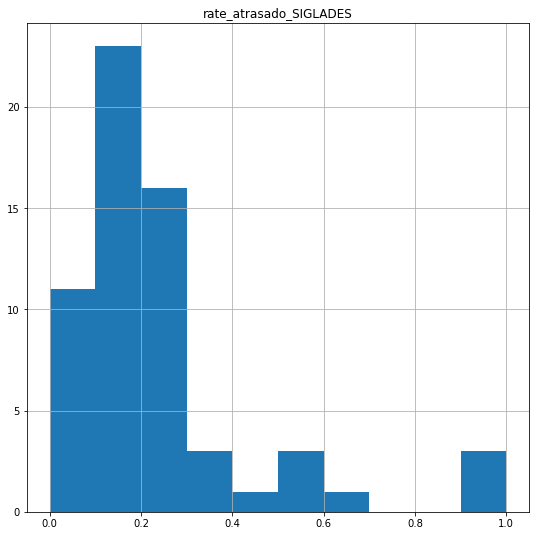

In [78]:
dest_rates.hist(bins = 10, figsize = (9,9))

In [79]:
newdest = []
for i in X.rate_atrasado_SIGLADES:
    if (i < 0.2):
        newdest.append("atraso_bajo")
    elif (0.2 <= i <= 0.4):
        newdest.append("atraso_medio")
    else:
        newdest.append("atraso_alto")
X['NEWDEST'] = newdest

## Sección 4.3 : Modelo sin incluir las Tasas

Utilizando las __Tasas__ se generaron diferentes variables como por ejemplo la clasificación de destinos según su frecuencia de viaje y también por su frecuencia de atraso. Por lo mismo, en éste primer modelo se decidió eliminar las tasas para ver cómo se comportaban los modelos solamente con variables categóricas.

In [80]:
X_mod_sin_rates = X.copy()

In [81]:
X_mod_sin_rates =X_mod_sin_rates.drop(['rate_atrasado_SIGLADES', 'rate_atrasado_OPERA',
       'rate_atrasado_month-O', 'rate_atrasado_DIANOM',
       'rate_atrasado_TIPOVUELO', 'rate_atrasado_periodo_dia'] , axis = 1)

In [82]:
X_mod_sin_rates.head()

,DIANOM,TIPOVUELO,OPERA,SIGLADES,temporada_alta,periodo_dia,atrasos_des,freq_atraso_siglades,atrasos_opera,freq_atraso_opera,NEWDEST
0,Domingo,I,American Airlines,Miami,1,noche,193,poco_frecuente_des,51,poco_frecuente_opera,atraso_bajo
1,Domingo,I,American Airlines,Miami,1,noche,193,poco_frecuente_des,51,poco_frecuente_opera,atraso_bajo
2,Domingo,I,American Airlines,Miami,1,noche,193,poco_frecuente_des,51,poco_frecuente_opera,atraso_bajo
3,Domingo,I,American Airlines,Miami,1,noche,193,poco_frecuente_des,51,poco_frecuente_opera,atraso_bajo
4,Domingo,I,American Airlines,Miami,1,noche,193,poco_frecuente_des,51,poco_frecuente_opera,atraso_bajo


In [83]:
dianom_categ = pd.get_dummies(X["DIANOM"], drop_first = True)
tipovuelo_categ = pd.get_dummies(X["TIPOVUELO"], drop_first = True)
periododia_categ = pd.get_dummies(X["periodo_dia"], drop_first = True)
newdest_categ = pd.get_dummies(X["NEWDEST"], drop_first = True)
opera_categ = pd.get_dummies(X["OPERA"], drop_first = True)
freq_atraso_siglades_categ = pd.get_dummies(X["freq_atraso_siglades"], drop_first = True)
freq_atraso_opera_categ = pd.get_dummies(X["freq_atraso_opera"], drop_first = True)
X_mod_sin_rates.drop(["DIANOM" , "TIPOVUELO" , "periodo_dia" , "NEWDEST" , "SIGLADES" , "OPERA" , "freq_atraso_siglades" , "freq_atraso_opera" , "atrasos_des" , "atrasos_opera" ] , axis = 1 , inplace = True)
X_mod_sin_rates = pd.concat([X_mod_sin_rates , dianom_categ , tipovuelo_categ , periododia_categ , newdest_categ , opera_categ , freq_atraso_siglades_categ , freq_atraso_opera_categ] , axis = 1)

In [84]:
from sklearn.model_selection import train_test_split

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_mod_sin_rates, y, test_size=0.2, random_state=42)

### Sección 4.3.1 : Logistic Regression

C:\Users\marce\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy 44.57813646368305 %
              precision    recall  f1-score   support

           0       0.90      0.36      0.52     11180
           1       0.22      0.82      0.35      2450

    accuracy                           0.45     13630
   macro avg       0.56      0.59      0.43     13630
weighted avg       0.78      0.45      0.49     13630



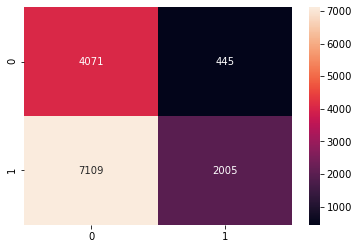

In [86]:
model = LogisticRegression(class_weight={1: 6},max_iter=1000)
model.fit(X_train, y_train)
y_pred1 = model.predict(X_test)
print('Accuracy {} %'.format(100 * accuracy_score(y_test,y_pred1)))
cm = confusion_matrix(y_pred1,y_test)
sns.heatmap(cm , annot = True , fmt='g')
print(classification_report(y_test , y_pred1))

### Sección 4.3.2 : XGBoost

[21:47:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy 63.98385913426266 %
              precision    recall  f1-score   support

           0       0.87      0.66      0.75     11180
           1       0.26      0.56      0.36      2450

    accuracy                           0.64     13630
   macro avg       0.57      0.61      0.55     13630
weighted avg       0.76      0.64      0.68     13630



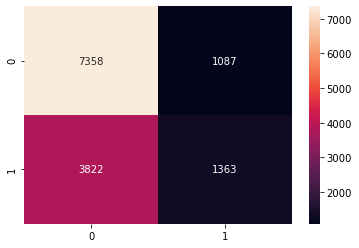

In [87]:
model = xgb.XGBClassifier(objective ='binary:logistic', learning_rate = 0.001, max_depth = 100, n_estimators = 1000,use_label_encoder =False , scale_pos_weight = 4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy {} %'.format(100 * accuracy_score(y_test,y_pred)))
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm , annot = True , fmt='g')
print(classification_report(y_test , y_pred))

### Sección 4.3.3 : Random Forest

<ipython-input-88-577145836293>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Accuracy 49.82391782831988 %
              precision    recall  f1-score   support

           0       0.89      0.44      0.59     11180
           1       0.23      0.75      0.35      2450

    accuracy                           0.50     13630
   macro avg       0.56      0.60      0.47     13630
weighted avg       0.77      0.50      0.55     13630



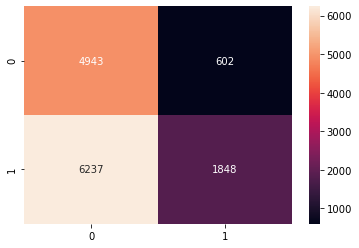

In [88]:
model = RandomForestClassifier(class_weight={1: 6})
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy {} %'.format(100 * accuracy_score(y_test,y_pred)))
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm , annot = True , fmt='g')
print(classification_report(y_test , y_pred))

### Sección 4.3.4 : Decision Tree

Accuracy 49.01687454145268 %
              precision    recall  f1-score   support

           0       0.89      0.43      0.58     11180
           1       0.23      0.77      0.35      2450

    accuracy                           0.49     13630
   macro avg       0.56      0.60      0.47     13630
weighted avg       0.77      0.49      0.54     13630



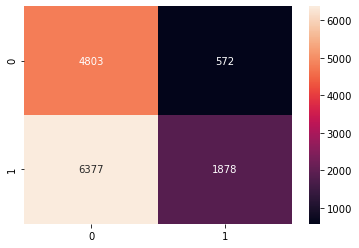

In [89]:
model = DecisionTreeClassifier(class_weight={1: 6})
model = model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print('Accuracy {} %'.format(100 * accuracy_score(y_test,y_pred)))
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm , annot = True , fmt='g')
print(classification_report(y_test , y_pred))

## Sección 4.4 : Modelo Solo Tasas

In [105]:
X_mod_solo_rates = X.copy()

In [106]:
X_mod_solo_rates.drop(["DIANOM" , "TIPOVUELO" , "periodo_dia" , "NEWDEST" , "SIGLADES" , "OPERA" , "freq_atraso_siglades" , "freq_atraso_opera" , "atrasos_des" , "atrasos_opera", "temporada_alta" ] , axis = 1 , inplace = True)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_mod_solo_rates, y, test_size=0.2, random_state=42)

### Sección 4.4.1 : Logistic Regression

C:\Users\marce\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy 50.11005135730008 %
              precision    recall  f1-score   support

           0       0.90      0.44      0.59     11180
           1       0.23      0.79      0.36      2450

    accuracy                           0.50     13630
   macro avg       0.57      0.61      0.48     13630
weighted avg       0.78      0.50      0.55     13630



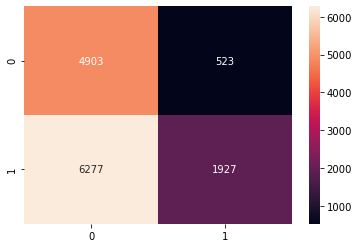

In [110]:
model = LogisticRegression(class_weight={1: 6},max_iter=1000)
model.fit(X_train, y_train)
y_pred1 = model.predict(X_test)
print('Accuracy {} %'.format(100 * accuracy_score(y_test,y_pred1)))
cm = confusion_matrix(y_pred1,y_test)
sns.heatmap(cm , annot = True , fmt='g')
print(classification_report(y_test , y_pred1))

### Sección 4.4.2 : XGBoost

[22:26:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy 65.84005869405722 %
              precision    recall  f1-score   support

           0       0.88      0.68      0.77     11180
           1       0.28      0.56      0.37      2450

    accuracy                           0.66     13630
   macro avg       0.58      0.62      0.57     13630
weighted avg       0.77      0.66      0.69     13630



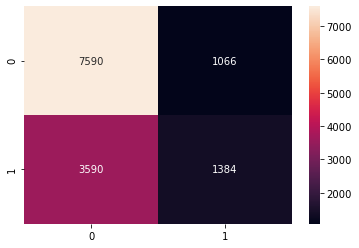

In [111]:
model = xgb.XGBClassifier(objective ='binary:logistic', learning_rate = 0.001, max_depth = 100, n_estimators = 1000,use_label_encoder =False , scale_pos_weight = 4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy {} %'.format(100 * accuracy_score(y_test,y_pred)))
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm , annot = True , fmt='g')
print(classification_report(y_test , y_pred))

### Sección 4.4.3 : Random Forest

<ipython-input-112-577145836293>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Accuracy 56.346294937637566 %
              precision    recall  f1-score   support

           0       0.89      0.53      0.67     11180
           1       0.25      0.71      0.37      2450

    accuracy                           0.56     13630
   macro avg       0.57      0.62      0.52     13630
weighted avg       0.78      0.56      0.61     13630



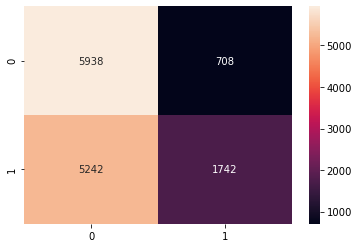

In [112]:
model = RandomForestClassifier(class_weight={1: 6})
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy {} %'.format(100 * accuracy_score(y_test,y_pred)))
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm , annot = True , fmt='g')
print(classification_report(y_test , y_pred))

### Sección 4.4.4 : Decision Tree

Accuracy 54.44607483492297 %
              precision    recall  f1-score   support

           0       0.90      0.50      0.64     11180
           1       0.24      0.74      0.37      2450

    accuracy                           0.54     13630
   macro avg       0.57      0.62      0.51     13630
weighted avg       0.78      0.54      0.59     13630



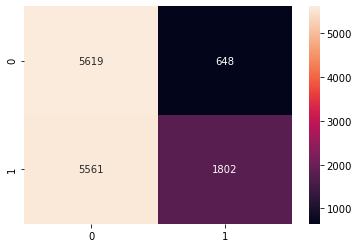

In [113]:
model = DecisionTreeClassifier(class_weight={1: 6})
model = model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print('Accuracy {} %'.format(100 * accuracy_score(y_test,y_pred)))
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm , annot = True , fmt='g')
print(classification_report(y_test , y_pred))

## Sección 4.5 : Modelo incluyendo Tasas y Variables Anteriores

In [90]:
X_mod_all = X.copy()

In [91]:
dianom_categ = pd.get_dummies(X_mod_all["DIANOM"], drop_first = True)
tipovuelo_categ = pd.get_dummies(X_mod_all["TIPOVUELO"], drop_first = True)
periododia_categ = pd.get_dummies(X_mod_all["periodo_dia"], drop_first = True)
newdest_categ = pd.get_dummies(X_mod_all["NEWDEST"], drop_first = True)
opera_categ = pd.get_dummies(X_mod_all["OPERA"], drop_first = True)
freq_atraso_siglades_categ = pd.get_dummies(X["freq_atraso_siglades"], drop_first = True)
freq_atraso_opera_categ = pd.get_dummies(X["freq_atraso_opera"], drop_first = True)
X_mod_all.drop(["DIANOM" , "TIPOVUELO" , "periodo_dia" , "NEWDEST" , "SIGLADES" , "OPERA" , "freq_atraso_siglades" , "freq_atraso_opera" , "atrasos_des" , "atrasos_opera" ] , axis = 1 , inplace = True)
X_mod_all = pd.concat([X_mod_all , dianom_categ , tipovuelo_categ , periododia_categ , newdest_categ , opera_categ , freq_atraso_siglades_categ , freq_atraso_opera_categ] , axis = 1)

In [92]:
X_mod_all.head(2)

,temporada_alta,rate_atrasado_SIGLADES,rate_atrasado_OPERA,rate_atrasado_month-O,rate_atrasado_DIANOM,rate_atrasado_TIPOVUELO,rate_atrasado_periodo_dia,Jueves,Lunes,Martes,Miercoles,Sabado,Viernes,N,noche,tarde,atraso_bajo,atraso_medio,Aeromexico,Air Canada,Air France,Alitalia,American Airlines,Austral,Avianca,British Airways,Copa Air,Delta Air,Gol Trans,Grupo LATAM,Iberia,JetSmart SPA,K.L.M.,Lacsa,Latin American Wings,Oceanair Linhas Aereas,Plus Ultra Lineas Aereas,Qantas Airways,Sky Airline,United Airlines,muy_frecuente_des,poco_frecuente_des,muy_frecuente_opera,poco_frecuente_opera
0,1,0.19,0.07,0.16,0.16,0.23,0.2,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,1,0.19,0.07,0.16,0.16,0.23,0.2,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_mod_all, y, test_size=0.2, random_state=42)

### Sección 4.5.1 : Logistic Regression

C:\Users\marce\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy 50.47688921496698 %
              precision    recall  f1-score   support

           0       0.91      0.44      0.59     11180
           1       0.24      0.79      0.36      2450

    accuracy                           0.50     13630
   macro avg       0.57      0.62      0.48     13630
weighted avg       0.79      0.50      0.55     13630



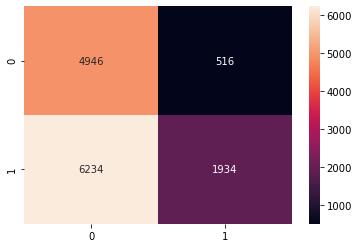

In [94]:
model = LogisticRegression(class_weight={1: 6},max_iter=1000)
model.fit(X_train, y_train)
y_pred1 = model.predict(X_test)
print('Accuracy {} %'.format(100 * accuracy_score(y_test,y_pred1)))
cm = confusion_matrix(y_pred1,y_test)
sns.heatmap(cm , annot = True , fmt='g')
print(classification_report(y_test , y_pred1))

### Sección 4.5.2 : XGBoost

[21:48:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy 66.77182685253118 %
              precision    recall  f1-score   support

           0       0.88      0.69      0.77     11180
           1       0.28      0.56      0.38      2450

    accuracy                           0.67     13630
   macro avg       0.58      0.62      0.57     13630
weighted avg       0.77      0.67      0.70     13630



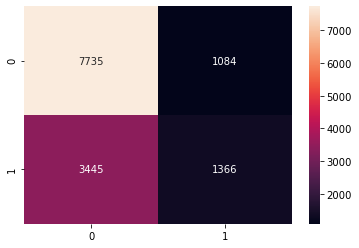

In [95]:
model = xgb.XGBClassifier(objective ='binary:logistic', learning_rate = 0.001, max_depth = 100, n_estimators = 1000,use_label_encoder =False , scale_pos_weight = 4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy {} %'.format(100 * accuracy_score(y_test,y_pred)))
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm , annot = True , fmt='g')
print(classification_report(y_test , y_pred))

### Sección 4.5.3 : Random Forest

<ipython-input-96-577145836293>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Accuracy 65.54658840792371 %
              precision    recall  f1-score   support

           0       0.87      0.68      0.77     11180
           1       0.27      0.52      0.35      2450

    accuracy                           0.66     13630
   macro avg       0.57      0.60      0.56     13630
weighted avg       0.76      0.66      0.69     13630



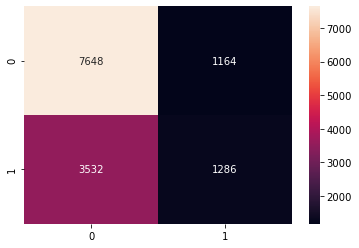

In [96]:
model = RandomForestClassifier(class_weight={1: 6})
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy {} %'.format(100 * accuracy_score(y_test,y_pred)))
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm , annot = True , fmt='g')
print(classification_report(y_test , y_pred))

### Sección 4.5.4 : Decision Tree

Accuracy 59.42039618488628 %
              precision    recall  f1-score   support

           0       0.87      0.59      0.71     11180
           1       0.24      0.60      0.35      2450

    accuracy                           0.59     13630
   macro avg       0.56      0.60      0.53     13630
weighted avg       0.76      0.59      0.64     13630



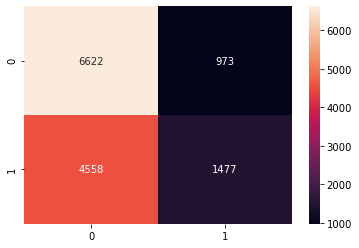

In [97]:
model = DecisionTreeClassifier(class_weight={1: 6})
model = model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print('Accuracy {} %'.format(100 * accuracy_score(y_test,y_pred)))
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm , annot = True , fmt='g')
print(classification_report(y_test , y_pred))

# Sección 5 : Evaluación de Modelos

Es evidente el gran desbalanceo que existe entre vuelos atrasados y no atrasados. Por lo mismo no podemos utilizar __Accuracy__ como métrica de evaluación ya que podríamos tener un modelo que dijera que todos los vuelos serán puntuales y tendríamos un __Accuracy de 82% (11180 / 13630)__.  

Para éstos casos debemos fijarnos en la __Precisión y/o Recall__ del modelo. La decisión de qué medida privilegiar depende del problema que queremos resolver y nuestro usuario final. Es decir, qué nos importa más, evitar los __Falsos Positivos (Decir que un vuelo se va a atrasar, pero en realidad no se atrasa)__ o los __Falsos Negativos (Decir que un vuelo será puntual, pero en realidad se atrasará__. 

Considerando la experiencia del usuario y luego de una breve encuesta realizada a algunas personas, lo mejor es evitar los __Falsos Negativos__ ya que si una persona cree que su vuelo saldrá a la hora y éste no lo hace, tendrá que mover de forma apresurada todos sus planes futuros : reuniones , eventos, comidas, etc. Sin embargo, si un pasajero es notificado que su vuelo saldrá más tarde podrá reagendar, no todos, pero sin duda alguna y de mejor manera sus futuros eventos. Si además el vuelo llega de forma puntual, será un mayor beneficio para el pasajero. Por lo anterior es que la métrica utilizada para evaluar los modelos corresponde a __Recall__.

Se ejecutaron diferentes modelos con difrentes combinaciones de variables. Por un tema de espacio y resultados no se colocaron todos y solamente algunos que permiten explicar la gran mayoría de los resultados. Hay que partir de la base que se trata de un problema con un fuerte desbalanceo lo que aumenta aun más su dificultad.  

Si nos vamos a la medida que nos interesa, que es __Recall__ el mejor modelo fue la __Regresión Logística__ utilizando sin incluir tasas  obteniendo un __82%__ en la métrica especificada. De los 2450 vuelos realmente atrasados, el modelo logra detectar correctamente 2005. Sin embargo, ésto va a costa de una precisión muy baja (22%), esto quiere decir que de los 9114 vuelos predichos como atrasados, 7109 fueron incorrectamente clasificados.

Ahora también podríamos escoger un XGBoost con una considerable menor Recall (__56%__), pero logra clasificar una mayor cantidad de vuelos puntuales de forma correcta. En particular logra clasificar mejor 3300 vuelos, una considerable mejora en comparación a lo anterior. El resto de los modelos no marcó una gran diferencia en comparación a éstos dos que fueron los principales. 

Mezclar todas las variables tanto las tasas como otras variables categóricas resultó en un aumento en las métricas, no considerable, pero un aumento al fin y al cabo

Sin duda alguna hay una gran cantidad de mejoras que se pueden realizar como la creación de nuevas variables , creación de cadenas de modelos que permitieran reducir la variabilidad de los datos, aumentar la cantidad de datos con las cuáles trabajar entre otras.